# Modelagem
O objetivo desse notebook é desenvolver um modelo capaz de prever os preços de cada anúncios, utilizando os conjuntos de dados previamente processados.

In [163]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, cross_val_score,cross_validate,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from scipy.stats import boxcox
from scipy.special import inv_boxcox

import xgboost as xgb

# Funções úteis

In [164]:
def get_scorers(model,X_test,y_test,lbda=None):
    yhat = model.predict(X_test)
    if lbda:
        yhat = inv_boxcox(yhat,lbda)
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test,yhat))))
    print('MAE: {}'.format(mean_absolute_error(y_test,yhat)))
    print('R2: {}'.format(r2_score(y_test,yhat)))
    return r2_score(y_test,yhat)

def plot_predictions(y,yhat):
    plt.scatter(x=y,y=yhat,alpha=0.7)
    plt.plot([2.5, 4.5], [2.5, 4.5], linewidth=2,c='r')
    plt.show()
    
def plot_residual(y,yhat):
    residuals = y - yhat
    plt.scatter(x=y,y=residuals,alpha=0.7)
    plt.plot([2.5, 4.5], [0, 0], linewidth=2,c='r')
    plt.show()    

# Inputs

In [165]:
# Features usadas no modelo
with open('./../dados_processados/model_features.pkl','rb') as f:
    model_features = pickle.load(f)

In [166]:
# Train Dataset
train_dataset = pd.read_csv('./../dados_processados/train_dataset.csv')
train_dataset = train_dataset[model_features].set_index('id')

y_train = train_dataset['price']
X_train = train_dataset.drop('price',axis=1)

In [167]:
# Test Dataset
test_dataset = pd.read_csv('./../dados_processados/test_dataset.csv')
test_dataset = test_dataset[model_features].set_index('id')

y_test = test_dataset['price']
X_test = test_dataset.drop('price',axis=1)

# Transformação da variável dependente
Dada a distribuição assimétrica dos preços, junto com um número considerável de possíveis outliers, optei por fazer uma transformação do tipo log na variável dependente

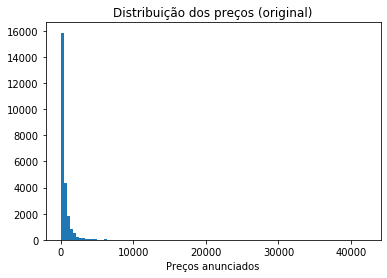

In [168]:
# Distribuição assimétrica
plt.hist(y_train,bins=100)
plt.title('Distribuição dos preços (original)')
plt.xlabel('Preços anunciados')
plt.show()

In [169]:
# Transformação Box-Cox
y_train,lbda = boxcox(y_train)

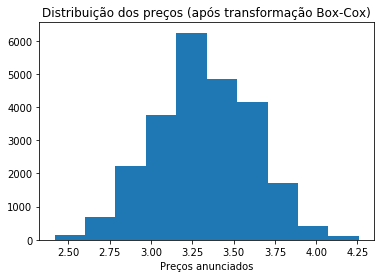

In [170]:
# Distribuição mais normal e simétrica
plt.hist(y_train)
plt.title('Distribuição dos preços (após transformação Box-Cox)')
plt.xlabel('Preços anunciados')
plt.show()

## Regressores LIneares

### OLS

In [171]:
model = LinearRegression()
cv_results = cross_validate(model,X_train,y_train,cv=6,n_jobs=-1)

fitted_model = model.fit(X_train,y_train)
train_score = get_scorers(model,X_train,y_train)
validation_score = cv_results['test_score'].mean()
std_validation_score_score = cv_results['test_score'].std()

print('R2 de treino: {}'.format(train_score))
print('R2 de validacao: {} +- {}'.format(validation_score,std_validation_score_score))

RMSE: 0.19724115617759386
MAE: 0.15201744153544514
R2: 0.5446948957516693
R2 de treino: 0.5446948957516693
R2 de validacao: 0.5145997496500699 +- 0.04063401079653154


### Lasso

In [172]:
model = Lasso(alpha=0.000001)
cv_results = cross_validate(model,X_train,y_train,cv=6,n_jobs=-1)

fitted_model = model.fit(X_train,y_train)
train_score = get_scorers(model,X_train,y_train)
validation_score = cv_results['test_score'].mean()
std_validation_score_score = cv_results['test_score'].std()

print('R2 de treino: {}'.format(train_score))
print('R2 de validacao: {} +- {}'.format(validation_score,std_validation_score_score))

RMSE: 0.19724115711538023
MAE: 0.1520173318494002
R2: 0.5446948914221578
R2 de treino: 0.5446948914221578
R2 de validacao: 0.5146021166260394 +- 0.04063413630851264


C:\Users\henri\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.32128173592344, tolerance: 0.20783069979650992
  positive)


In [173]:
# Grid Search para encontrar melhor parâmetro de alpha do Lasso
params = {'alpha': np.logspace(-5,1,10)}

gridsearch_cv = RandomizedSearchCV(estimator=Lasso(),
                                   param_distributions=params,
                                   cv=6,
                                   n_jobs=-1,
                                   n_iter=10
                                  )
gridsearch_cv.fit(X_train,y_train)
gridsearch_cv.best_score_

C:\Users\henri\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229.82408404002928, tolerance: 0.20783069979650992
  positive)


0.5146457710185289

Conclusão: Regressores lineares não produzem o resultado esperado

# Regressores não lineares

## Random Forests

In [174]:
model = RandomForestRegressor(n_estimators=50,
                              min_samples_split=10,
                              min_samples_leaf=10,
                              max_features='auto')

In [175]:
cv_results = cross_validate(model,X_train,y_train,cv=6,n_jobs=-1)

fitted_model = model.fit(X_train,y_train)
train_score = get_scorers(model,X_train,y_train)
validation_score = cv_results['test_score'].mean()
std_validation_score_score = cv_results['test_score'].std()

print('R2 de treino: {}'.format(train_score))
print('R2 de validacao: {} +- {}'.format(validation_score,
                                         std_validation_score_score)
     )

RMSE: 0.14585775871910828
MAE: 0.10946505144469303
R2: 0.7510188253715132
R2 de treino: 0.7510188253715132
R2 de validacao: 0.5613566914432503 +- 0.02722230317215994


In [146]:
# Grid Search para encontrar melhor conjunto de hiperparâmetros
params = {'n_estimators': [50,100,150,200],
         'min_samples_split': [20,50,100,200],
         'min_samples_leaf': [20,50,100,200],
          'max_features':[10,30,50]
         }
gridsearch_cv = RandomizedSearchCV(estimator=RandomForestRegressor(),
                                   param_distributions = params,
                                   cv=6,
                                   n_jobs=-1,
                                   n_iter=100
            )
gridsearch_cv.fit(X_train,y_train)
gridsearch_cv.best_score_

0.5623670863648721

## XGBoost

In [176]:
model = xgb.XGBRegressor(n_estimators=50,
                         colsample_bytree = 0.7,
                         colsample_bylevel = 0.7,
                         min_samples_split=100,
                         min_samples_leaf=100,
                         reg_alpha = 10,
                         reg_lambda = 1,
                         subsample=0.7,
                         base_score=np.median(y_train)
                        )

cv_results = cross_validate(model,X_train,y_train,cv=6,n_jobs=-1)

fitted_model = model.fit(X_train,y_train)
train_score = get_scorers(fitted_model,X_train,y_train)
validation_score = cv_results['test_score'].mean()
std_validation_score_score = cv_results['test_score'].std()

print('R2 de treino: {}'.format(train_score))
print('R2 de validacao: {} +- {}'.format(validation_score,
                                         std_validation_score_score)
     )

RMSE: 0.16868500145650592
MAE: 0.1284939674019222
R2: 0.6669876205636642
R2 de treino: 0.6669876205636642
R2 de validacao: 0.5797605562580201 +- 0.028524941903907985


In [ ]:
params = {'n_estimators': [50,100,150,200],
         'colsample_bytree' :  [0.5,0.7,1.0],
         'colsample_bylevel' :  [0.5,0.7,1.0],
         'min_samples_split': [20,50,100,200],
         'min_samples_leaf': [20,50,100,200],
         'reg_alpha' :  [1,10,100],
         'reg_lambda' :  [1,10,100],
         'subsample': [0.5,0.7,1.0],
         'base_score': [np.median(y_train)]
         }
gridsearch_cv = RandomizedSearchCV(estimator=xgb.XGBRegressor(),
                                     param_distributions = params,
                                     cv=6,
                                   n_jobs=-1,
                                   n_iter=10
            )
gridsearch_results = gridsearch_cv.fit(X_train,y_train)
gridsearch_results.best_score_

O XGBoost mostrou um melhor resultado entre os modelos testados.

In [188]:
best_model = gridsearch_results.best_estimator_

## Resultados no conjunto de teste

In [194]:
fitted_model = best_model.fit(X_train,y_train)
test_score = get_scorers(fitted_model,X_test,boxcox(y_test,lbda))

RMSE: 0.17281107752608987
MAE: 0.1308169542851158
R2: 0.6575359892621087


A diferença entre o R2 de treino e o R2 de teste não é tão expressiva. Além disso, a variação do R2 de teste entre os Folds é pequena, o que me traz mais confiança sobre o poder de generalização do meu modelo

Vale lembrar que estamos no espaço transformado do preço. 

Caso houvesse mais tempo para o teste, seria interessante estudar a performance do modelo no espaço original e avaliar seus resultados

In [196]:
with open('./../dados_processados/best_model_xgboost.pkl','wb') as f:
    pickle.dump(best_model,f)

## Análise das previsões e residuos

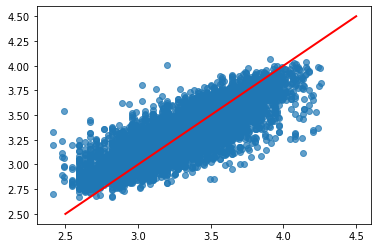

In [197]:
plot_predictions(y = boxcox(y_test,lbda),
                 yhat = best_model.predict(X_test))

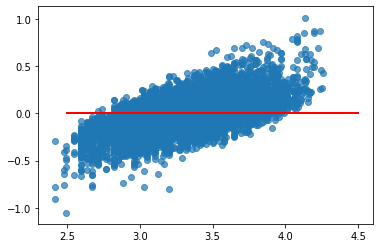

In [198]:
plot_residual(y=boxcox(y_test,lbda),
              yhat=best_model.predict(X_test))